# Convert data to  TFRecord file format

Convert the images and bounding boxes to the TensorFlow [TFRecord file format](https://www.tensorflow.org/api_guides/python/python_io#tfrecords_format_details).

Based on [this example](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/using_your_own_dataset.md) from the object detection framework.

In [1]:
import os
import sys
import pathlib
import pandas as pd
import json

import cv2
from matplotlib import pyplot as plt
import tensorflow as tf

from IPython.display import display

In [2]:
TRAINING_FILE = 'train_files.csv'
TESTING_FILE = 'test_files.csv'
TRAINING_RECORDS = 'hands_train.record'
TESTING_RECORDS = 'hands_test.record'

In [3]:
def int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def int64_list_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def bytes_list_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

def float_list_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

In [4]:
def create_tf_example(row):
    """
    Create a tf.Example proto from the image represented by the given row.
    """
    path = row['path']
    boxes_list = json.loads(row['boxes'])
    img = cv2.imread(path)
    height, width, channels = img.shape 
    assert channels == 3
    filename = os.path.basename(path).encode() # Filename of the image. Empty if image is not from file
    encoded_image_data = cv2.imencode('.jpg', img)[1].tostring() # Encoded image bytes
    image_format = 'jpeg'.encode()
    ymins, xmins, ymaxs, xmaxs = zip(*boxes_list)
    ymins = [y / height for y in ymins]
    xmins = [x / width for x in xmins]
    ymaxs = [y / height for y in ymaxs]
    xmaxs = [x / width for x in xmaxs]
    classes_text = ['hands'.encode() for _ in boxes_list] # List of string class name of bounding box (1 per box)
    classes = [1 for _ in boxes_list] # List of integer class id of bounding box (1 per box)
    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': int64_feature(height),
        'image/width': int64_feature(width),
        'image/filename': bytes_feature(filename),
        'image/source_id': bytes_feature(filename),
        'image/encoded': bytes_feature(encoded_image_data),
        'image/format': bytes_feature(image_format),
        'image/object/bbox/xmin': float_list_feature(xmins),
        'image/object/bbox/xmax': float_list_feature(xmaxs),
        'image/object/bbox/ymin': float_list_feature(ymins),
        'image/object/bbox/ymax': float_list_feature(ymaxs),
        'image/object/class/text': bytes_list_feature(classes_text),
        'image/object/class/label': int64_list_feature(classes),
    }))
    return tf_example

In [5]:
def create_record(df, output_path):
    """
    Create records from the given dataframe and save them to the output file.
    """
    writer = tf.python_io.TFRecordWriter(output_path)

    for _, row in df.iterrows():
        tf_example = create_tf_example(row)
        writer.write(tf_example.SerializeToString())

    writer.close()
    print('Examples written to {}'.format(output_path))

In [6]:
print('Converting training data')
df_train = pd.read_csv(TRAINING_FILE, header=0, index_col=0)

# Display some samples
with pd.option_context('display.max_rows', 5, 'display.max_columns', 3):
    display(df_train)
    
create_record(df_train, TRAINING_RECORDS)

Converting training data


,path,boxes
0,/Users/42155/Workspace/tensorflow_experiments/...,"[[679, 753, 718, 806], [229, 691, 328, 807], [..."
1,/Users/42155/Workspace/tensorflow_experiments/...,"[[675, 740, 718, 803], [365, 649, 534, 816], [..."
...,...,...
4305,/Users/42155/Workspace/tensorflow_experiments/...,"[[349, 138, 692, 484], [328, 527, 584, 870], [..."
4306,/Users/42155/Workspace/tensorflow_experiments/...,"[[345, 104, 605, 477], [340, 431, 712, 777], [..."


Examples written to hands_train.record


In [7]:
print('Converting testing data')
df_test = pd.read_csv(TESTING_FILE, header=0, index_col=0)

# Display some samples
with pd.option_context('display.max_rows', 5, 'display.max_columns', 3):
    display(df_test)
    
create_record(df_test, TESTING_RECORDS)

Converting testing data


,path,boxes
0,/Users/42155/Workspace/tensorflow_experiments/...,"[[419, 825, 718, 1042], [297, 734, 396, 849], ..."
1,/Users/42155/Workspace/tensorflow_experiments/...,"[[617, 769, 718, 994], [299, 654, 391, 761], [..."
...,...,...
478,/Users/42155/Workspace/tensorflow_experiments/...,"[[491, 102, 718, 427], [446, 674, 717, 868], [..."
479,/Users/42155/Workspace/tensorflow_experiments/...,"[[489, 86, 716, 400], [436, 664, 716, 845], [5..."


Examples written to hands_test.record


## Show some samples

height: 720, width: 1280
filename: b'frame_0014.jpg', source_id: b'frame_0014.jpg', img_format: b'jpeg'
image:  <class 'numpy.ndarray'> (720, 1280, 3)
text: [b'hands' b'hands' b'hands'], label: [1 1 1]
boxes_list:  3 [(0.94305557, 0.5882813, 0.99722224, 0.6296875), (0.31805557, 0.53984374, 0.45555556, 0.6304687), (0.31805557, 0.45703125, 0.4513889, 0.5367187)]


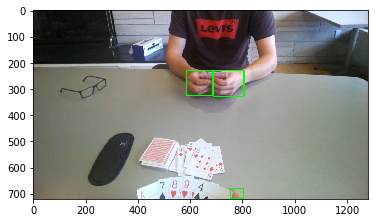

In [8]:
# Start session
sess = tf.InteractiveSession()

# Setup reaer
reader = tf.TFRecordReader()
filename_queue = tf.train.string_input_producer([TRAINING_RECORDS, TESTING_RECORDS])
_, serialized_example = reader.read(filename_queue)

# How features should be extracted
features = {
    'image/height': tf.FixedLenFeature([], tf.int64),
    'image/width': tf.FixedLenFeature([], tf.int64),
    'image/filename': tf.FixedLenFeature([], dtype=tf.string),
    'image/source_id': tf.FixedLenFeature([], dtype=tf.string),
    'image/encoded': tf.FixedLenFeature([], dtype=tf.string),
    'image/format': tf.FixedLenFeature([], dtype=tf.string),
    'image/object/bbox/xmin': tf.VarLenFeature(dtype=tf.float32),
    'image/object/bbox/xmax': tf.VarLenFeature(dtype=tf.float32),
    'image/object/bbox/ymin': tf.VarLenFeature(dtype=tf.float32),
    'image/object/bbox/ymax': tf.VarLenFeature(dtype=tf.float32),
    'image/object/class/text': tf.VarLenFeature(dtype=tf.string),
    'image/object/class/label': tf.VarLenFeature(dtype=tf.int64)
}

# Read the serialized data
single_example = tf.parse_single_example(
    serialized=serialized_example,
    features=features)

# Start queue runner
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

# Evaluate a single example
image_tensor = tf.image.decode_image(single_example['image/encoded'], channels=3)
image_tensor.set_shape([None, None, 3])
(
    height, 
    width,
    filename,
    source_id,
    img_format,
    image,
    text,
    label,
    ymins,
    xmins,
    ymaxs,
    xmaxs,
) = sess.run([
    single_example['image/height'],
    single_example['image/width'],
    single_example['image/filename'],
    single_example['image/source_id'],
    single_example['image/format'],
    image_tensor,
    single_example['image/object/class/text'],
    single_example['image/object/class/label'],
    single_example['image/object/bbox/ymin'],
    single_example['image/object/bbox/xmin'],
    single_example['image/object/bbox/ymax'],
    single_example['image/object/bbox/xmax'],
])

# Show the single example
print('filename: {}, source_id: {}, img_format: {}'.format(filename, source_id, img_format))
print('height: {}, width: {}'.format(height, width))
print('image: ', type(image), image.shape)
print('text: {}, label: {}'.format(text.values, label.values))
# Convert boxes back from relative to absolute value
boxes_list = list(zip(ymins.values, xmins.values, ymaxs.values, xmaxs.values))
print('boxes_list: ', len(boxes_list), boxes_list)

for (ymin, xmin, ymax, xmax) in boxes_list:
    ymin = int(ymin * height)
    xmin = int(xmin * width)
    ymax = int(ymax * height)
    xmax = int(xmax * width)
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0,255,0), 3) 
plt.imshow(image)
plt.show()


# Close the session
coord.request_stop()
coord.join(threads=threads)
sess.close()